### 导包

In [2]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
# 支持向量机
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

### 数据聚合

In [5]:
train = pd.read_csv('./zhengqi_train.txt',sep = '\t')
test = pd.read_csv('./zhengqi_test.txt',sep = '\t')

In [8]:
train['origin'] = 'train'
test['origin'] = 'test'

data_all = pd.concat([train,test])
print(data_all.shape)
data_all.head()

(4813, 40)


,V0,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V5,V6,V7,V8,V9,origin,target
0,0.566,0.016,-0.940,-0.307,-0.073,0.550,-0.484,0.000,-1.707,-1.162,-0.573,-0.991,-0.143,0.610,-0.400,-0.063,0.356,0.800,-0.223,0.796,0.168,-0.450,0.136,0.407,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,train,0.175
1,0.968,0.437,0.188,-0.455,-0.134,1.109,-0.488,0.000,-0.977,-1.162,-0.571,-0.836,0.066,0.588,-0.802,-0.063,0.357,0.801,-0.144,1.057,0.338,0.671,-0.128,0.566,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.194,-0.893,-1.566,-2.360,0.332,-2.114,train,0.676
2,1.013,0.568,0.874,-0.051,-0.072,0.767,-0.493,-0.212,-0.618,-0.897,-0.564,-0.558,0.235,0.576,-0.477,-0.063,0.355,0.961,-0.067,0.915,0.326,1.287,-0.009,0.370,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.112,-0.797,-1.367,-2.360,0.396,-2.114,train,0.633
3,0.733,0.368,0.011,0.102,-0.014,0.769,-0.371,-0.162,-0.429,-0.897,-0.574,-0.564,0.283,0.272,-0.491,-0.063,0.352,1.435,0.113,0.898,0.277,1.298,0.015,0.165,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.599,-0.679,-1.200,-2.086,0.403,-2.114,train,0.206
4,0.684,0.638,-0.251,0.570,0.199,-0.349,-0.342,-0.138,-0.391,-0.897,-0.572,-0.394,0.260,0.106,0.309,-0.259,0.352,0.881,0.221,0.386,0.332,1.289,0.183,0.209,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.337,-0.454,-1.073,-2.086,0.314,-2.114,train,0.384


### 特征探索

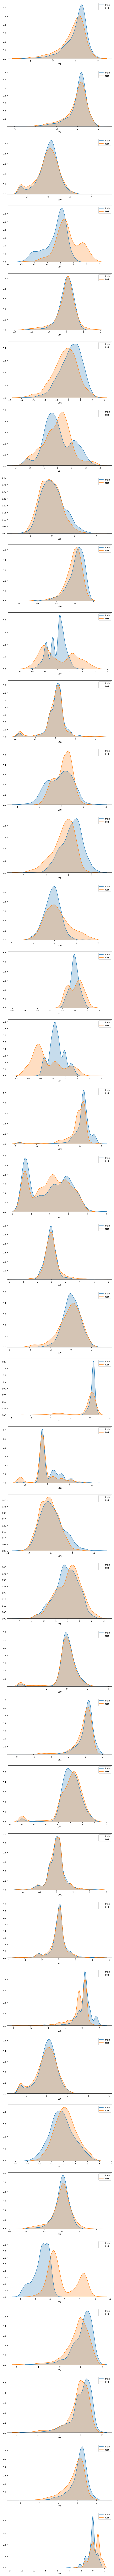

In [29]:
# 38个特征，将一些不重要的特征删除
# 特征分布情况，训练和测试数据特征分布不均匀，删除
plt.figure(figsize=(9,38*6))
for i,col in enumerate(data_all.columns[:-2]):
    cond = data_all['origin'] == 'train'
    train_col = data_all[col][cond] #训练数据
    cond = data_all['origin'] == 'test'
    test_col = data_all[col][cond] #测试数据
    axes = plt.subplot(38,1,i+1)
    ax = sns.kdeplot(train_col,shade = True)
    sns.kdeplot(test_col,shade = True,ax = ax)
    plt.legend(['train','test'])
    plt.xlabel(col)

<Figure size 648x432 with 0 Axes>

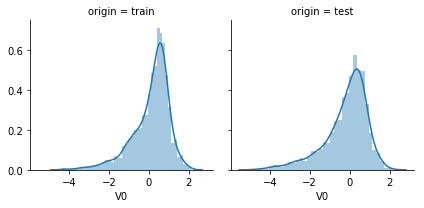

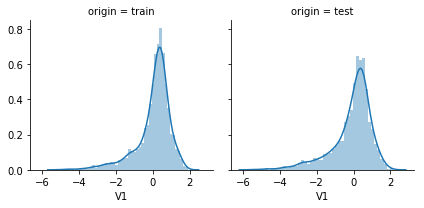

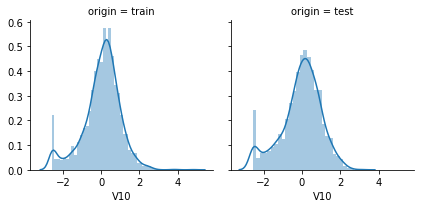

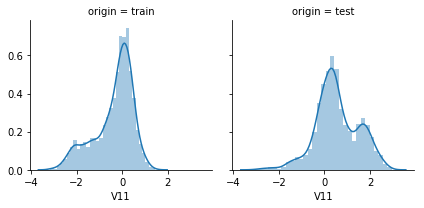

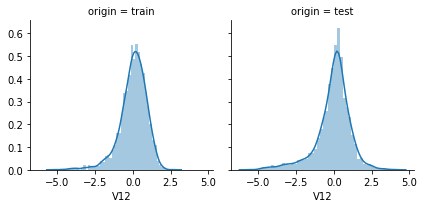

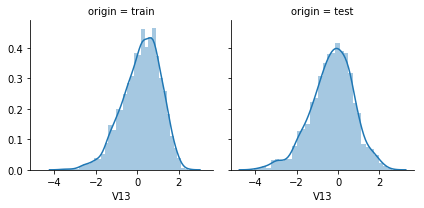

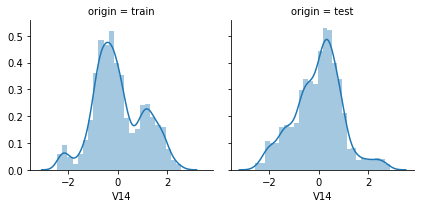

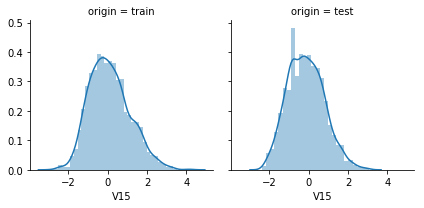

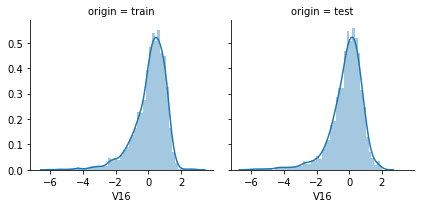

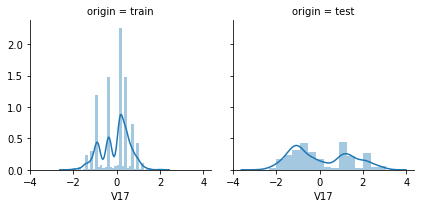

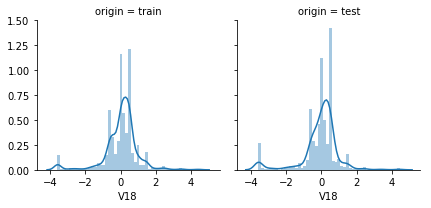

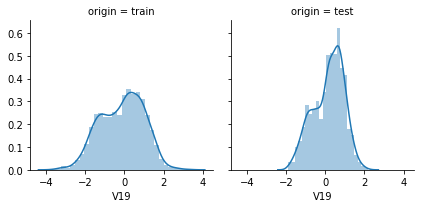

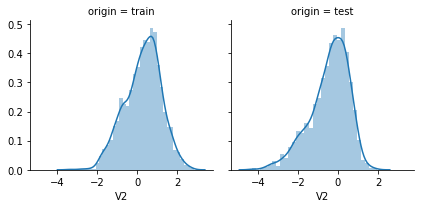

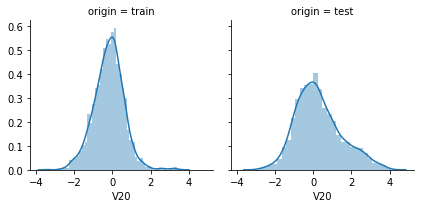

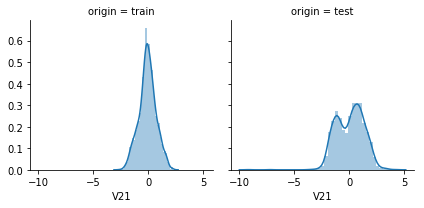

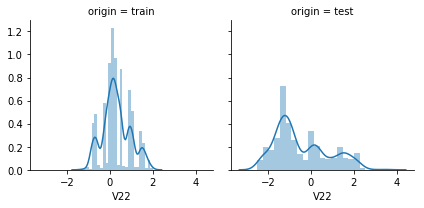

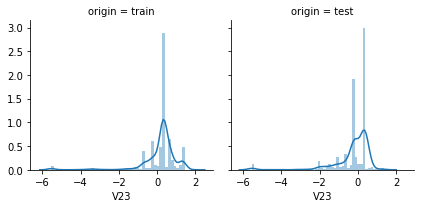

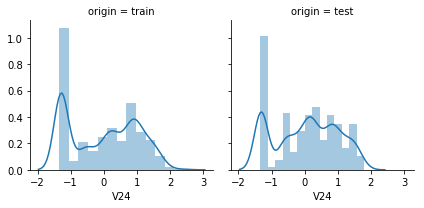

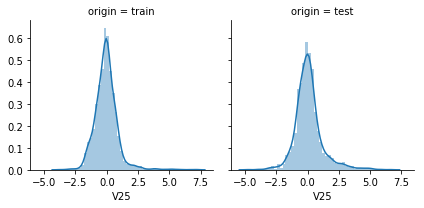

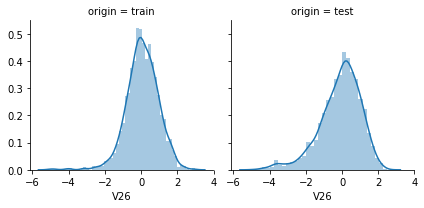

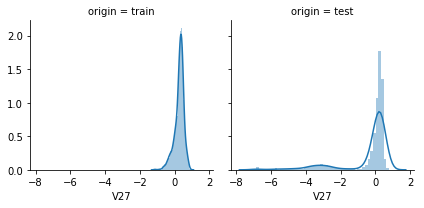

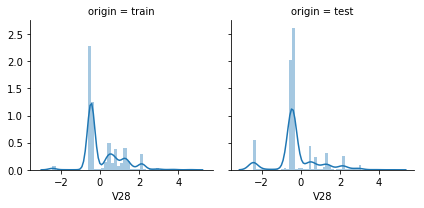

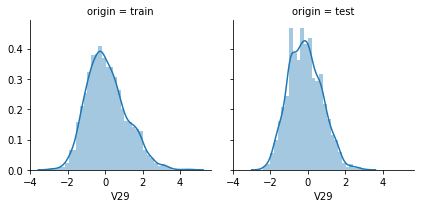

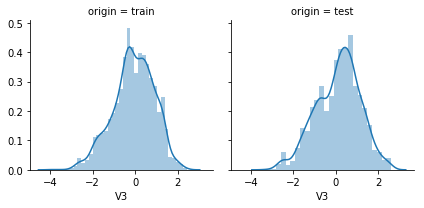

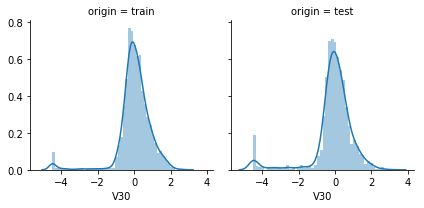

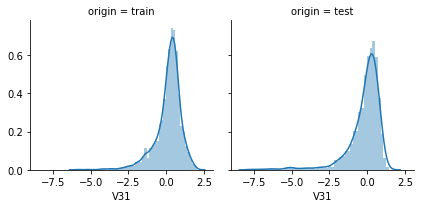

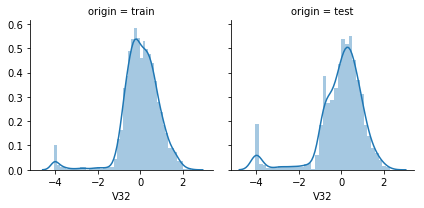

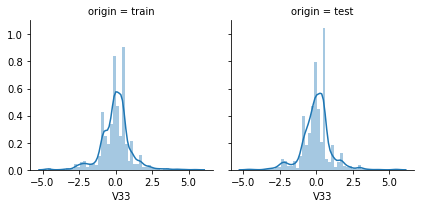

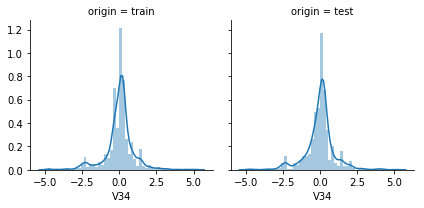

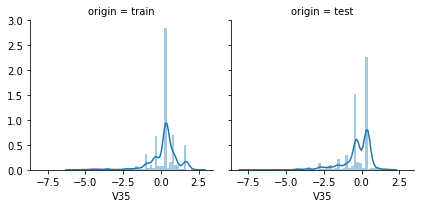

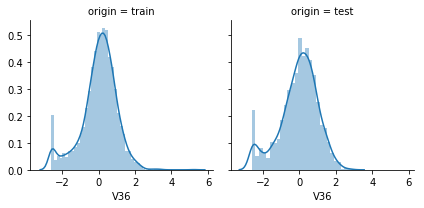

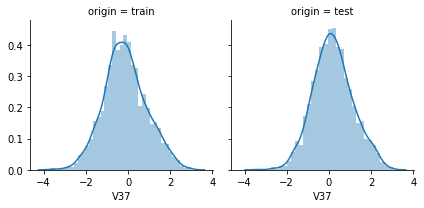

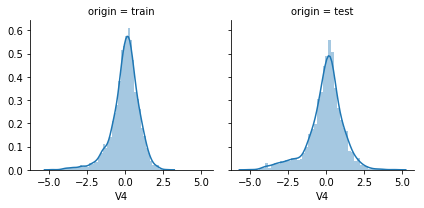

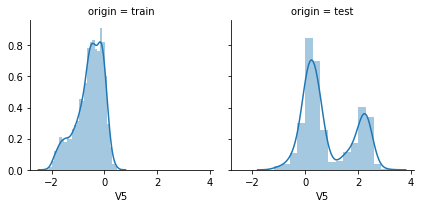

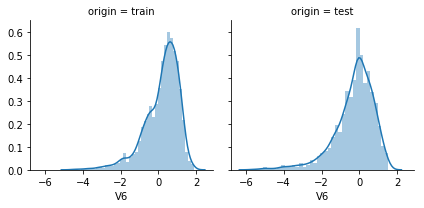

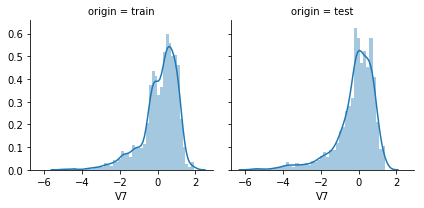

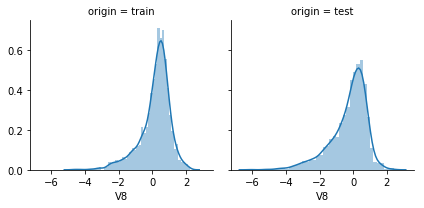

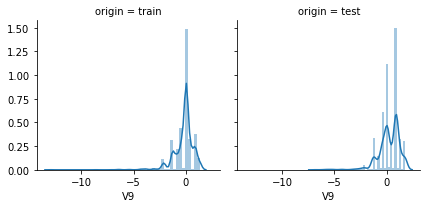

In [23]:
plt.figure(figsize=(9,6))
for col in data_all.columns[:-2]:
    g = sns.FacetGrid(data_all,col = 'origin')
    g.map(sns.distplot,col)#distribute 分配；散布；分开

In [30]:
drop_labels = ['V11','V17','V22','V5']
data_all.drop(drop_labels,axis = 1,inplace=True)
data_all.shape

(4813, 36)

#### 相关性系数corr

In [34]:
# 协方差
cov = data_all.cov()
cov.head()

,V0,V1,V10,V12,V13,V14,V15,V16,V18,V19,V2,V20,V21,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,target
V0,1.000025,0.903982,0.321419,0.724819,0.227613,0.047217,0.351832,0.304059,0.148834,-0.121430,0.340467,0.381376,0.057697,0.235854,-0.322164,-0.277353,-0.068489,0.170782,0.024270,0.329480,0.359285,0.172896,0.508813,0.064374,0.034760,-0.026891,0.162476,0.254698,-0.498201,0.784839,0.180416,0.151922,0.767856,0.053450,0.797374
V1,0.903982,1.000031,0.333186,0.615086,0.189003,0.026079,0.177391,0.404681,0.132534,-0.106672,0.401578,0.396083,0.041882,0.226535,-0.224249,-0.133716,0.014211,0.202618,0.054309,0.150990,0.359448,0.184071,0.605021,0.095879,0.016321,-0.028009,0.167848,0.258554,-0.515544,0.656987,0.262892,0.213077,0.856050,0.127983,0.807694
V10,0.321419,0.333186,1.000034,0.141233,-0.044205,-0.066704,-0.034576,0.557380,0.006353,0.090936,0.348495,0.265669,-0.000501,0.004447,-0.062511,0.045797,0.116874,0.201756,0.048581,-0.087782,0.354042,-0.000285,0.564971,-0.041345,0.014036,-0.008258,0.105840,0.927944,-0.045381,0.152349,0.441228,0.360234,0.408018,0.116110,0.376113
V12,0.724819,0.615086,0.141233,1.000027,0.128977,0.101724,0.625062,-0.053284,0.061986,-0.192903,-0.108489,0.194275,0.295039,0.114547,-0.526688,-0.528259,-0.164176,0.015888,-0.063148,0.648768,0.254820,0.023280,0.270322,-0.047248,0.001803,-0.054250,0.037329,0.119072,-0.042680,0.928831,-0.131589,-0.036766,0.306602,-0.012849,0.522741
V13,0.227613,0.189003,-0.044205,0.128977,1.000004,0.558107,0.053454,0.122070,0.257730,-0.171647,0.224002,-0.084727,-0.179707,0.166915,-0.103611,-0.067539,0.035548,-0.025223,0.035698,0.041397,-0.089332,0.086200,0.100126,0.136056,0.107571,0.041974,0.134536,-0.013154,-0.401541,0.134826,0.135847,0.096140,0.193717,-0.190371,0.184655


In [33]:
# 相关性系数
corr = data_all.corr()
corr.head()

,V0,V1,V10,V12,V13,V14,V15,V16,V18,V19,V2,V20,V21,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,target
V0,1.000000,0.903956,0.321410,0.724800,0.227610,0.047217,0.351828,0.304055,0.148831,-0.121418,0.340461,0.381375,0.057694,0.235851,-0.322101,-0.277339,-0.068486,0.170780,0.024269,0.329477,0.359282,0.172895,0.508807,0.064368,0.034757,-0.026891,0.162464,0.254690,-0.498186,0.784818,0.180407,0.151916,0.767851,0.053435,0.873212
V1,0.903956,1.000000,0.333175,0.615068,0.188999,0.026078,0.177389,0.404674,0.132532,-0.106661,0.401569,0.396081,0.041880,0.226531,-0.224204,-0.133709,0.014210,0.202615,0.054306,0.150988,0.359444,0.184069,0.605012,0.095870,0.016320,-0.028008,0.167835,0.258545,-0.515528,0.656967,0.262878,0.213067,0.856041,0.127948,0.871846
V10,0.321410,0.333175,1.000000,0.141228,-0.044204,-0.066702,-0.034576,0.557371,0.006353,0.090927,0.348486,0.265667,-0.000501,0.004447,-0.062498,0.045794,0.116868,0.201753,0.048579,-0.087781,0.354038,-0.000285,0.564962,-0.041341,0.014035,-0.008258,0.105831,0.927911,-0.045380,0.152344,0.441205,0.360217,0.408014,0.116079,0.394767
V12,0.724800,0.615068,0.141228,1.000000,0.128975,0.101722,0.625054,-0.053284,0.061985,-0.192885,-0.108487,0.194274,0.295021,0.114545,-0.526584,-0.528232,-0.164168,0.015888,-0.063146,0.648761,0.254818,0.023280,0.270319,-0.047244,0.001803,-0.054250,0.037326,0.119068,-0.042679,0.928805,-0.131583,-0.036765,0.306600,-0.012846,0.594189
V13,0.227610,0.188999,-0.044204,0.128975,1.000000,0.558105,0.053453,0.122069,0.257728,-0.171632,0.224000,-0.084727,-0.179698,0.166914,-0.103592,-0.067537,0.035547,-0.025223,0.035697,0.041398,-0.089332,0.086200,0.100126,0.136045,0.107563,0.041974,0.134527,-0.013154,-0.401534,0.134824,0.135842,0.096137,0.193717,-0.190322,0.203373


$$corr = cov/(std1*std2)$$

In [35]:
train.cov().head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
V0,0.861242,0.793900,0.392082,0.368809,0.644063,-0.157196,0.161252,0.125240,0.659824,0.068944,0.268177,-0.235367,0.623827,0.158547,-0.003906,0.301531,0.316919,0.027220,0.131508,-0.103208,0.338435,-0.021239,-0.062666,0.209945,-0.311646,-0.170608,-0.103332,0.183971,0.030307,0.297560,0.131386,0.546886,0.042678,0.052744,-0.018009,0.127087,0.208494,-0.466403,0.797374
V1,0.793900,0.886450,0.434560,0.350734,0.550188,-0.110841,0.239260,0.184368,0.737394,0.124690,0.282719,-0.159490,0.552378,0.136850,-0.005993,0.160194,0.403210,0.044842,0.111191,-0.096752,0.341349,-0.009499,-0.061637,0.205105,-0.227241,-0.060907,-0.036032,0.209809,0.067717,0.146969,0.149454,0.632707,0.072746,0.033306,-0.027502,0.135797,0.215072,-0.473147,0.807694
V2,0.392082,0.434560,0.830350,0.362641,0.046707,-0.152175,0.515271,0.415250,0.573972,0.041610,0.305289,-0.200587,0.048836,0.172174,-0.098357,-0.211402,0.700988,-0.011360,0.114777,-0.163490,0.214396,-0.022027,-0.123492,0.058426,0.009629,0.402123,0.028678,0.178929,0.194532,-0.266665,0.144603,0.520092,0.027916,0.046164,-0.023423,0.039204,0.279955,-0.681234,0.572834
V3,0.368809,0.350734,0.362641,0.941478,0.271566,-0.103684,0.208351,0.183344,0.357918,-0.058969,0.301830,-0.083707,0.265810,-0.003256,-0.229285,0.143797,0.376341,0.078847,0.021156,-0.264686,0.221566,0.086724,-0.180625,0.077280,-0.237969,-0.089381,-0.023901,0.102840,0.143498,0.121101,0.038477,0.357437,-0.080942,-0.006995,-0.031053,0.076545,0.305648,-0.226624,0.488898
V4,0.644063,0.550188,0.046707,0.271566,0.789213,-0.107654,-0.095854,-0.044436,0.357606,-0.026959,0.121398,-0.123940,0.736852,0.062295,0.021521,0.565054,0.020802,0.026104,0.115216,-0.202660,0.204060,0.120815,-0.016202,0.170884,-0.486444,-0.361595,-0.063621,0.098980,-0.036861,0.621357,0.018275,0.346696,-0.020997,0.055793,0.025544,0.087574,0.097982,-0.028062,0.527962


In [37]:
# 协方差是两个属性之间的关系，如果两个属性一样：方差
# 方差是协方差的一种特殊形式
# 圆是椭圆一种特殊形式
# 导数是偏导数的特殊形式
0.861242/(0.861242**0.5*0.861242**0.5)

1.0000000000000002

In [38]:
0.793900/(0.861242**0.5*0.886450**0.5)

0.9086070021397384

In [36]:
train.corr().head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
V0,1.000000,0.908607,0.463643,0.409576,0.781212,-0.327028,0.189267,0.141294,0.794013,0.077888,0.298443,-0.295420,0.751830,0.185144,-0.004144,0.314520,0.347357,0.044722,0.148622,-0.100294,0.462493,-0.029285,-0.105643,0.231136,-0.324959,-0.200706,-0.125140,0.733198,0.035119,0.302145,0.156968,0.675003,0.050951,0.056439,-0.019342,0.138933,0.231417,-0.494076,0.873212
V1,0.908607,1.000000,0.506514,0.383924,0.657790,-0.227289,0.276805,0.205023,0.874650,0.138849,0.310120,-0.197317,0.656186,0.157518,-0.006268,0.164702,0.435606,0.072619,0.123862,-0.092673,0.459795,-0.012911,-0.102421,0.222574,-0.233556,-0.070627,-0.043012,0.824198,0.077346,0.147096,0.175997,0.769745,0.085604,0.035129,-0.029115,0.146329,0.235299,-0.494043,0.871846
V2,0.463643,0.506514,1.000000,0.410148,0.057697,-0.322417,0.615938,0.477114,0.703431,0.047874,0.346006,-0.256407,0.059941,0.204762,-0.106282,-0.224573,0.782474,-0.019008,0.132105,-0.161802,0.298385,-0.030932,-0.212023,0.065509,0.010225,0.481785,0.035370,0.726250,0.229575,-0.275764,0.175943,0.653764,0.033942,0.050309,-0.025620,0.043648,0.316462,-0.734956,0.638878
V3,0.409576,0.383924,0.410148,1.000000,0.315046,-0.206307,0.233896,0.197836,0.411946,-0.063717,0.321262,-0.100489,0.306397,-0.003636,-0.232677,0.143457,0.394517,0.123900,0.022868,-0.246008,0.289594,0.114373,-0.291236,0.081374,-0.237326,-0.100569,-0.027685,0.392006,0.159039,0.117610,0.043966,0.421954,-0.092423,-0.007159,-0.031898,0.080034,0.324475,-0.229613,0.512074
V4,0.781212,0.657790,0.057697,0.315046,1.000000,-0.233959,-0.117529,-0.052370,0.449542,-0.031816,0.141129,-0.162507,0.927685,0.075993,0.023853,0.615704,0.023818,0.044803,0.136022,-0.205729,0.291309,0.174025,-0.028534,0.196530,-0.529866,-0.444375,-0.080487,0.412083,-0.044620,0.659093,0.022807,0.447016,-0.026186,0.062367,0.028659,0.100010,0.113609,-0.031054,0.603984


In [46]:
# 通过相关性系数找到7个相关性不大的属性
cond = corr.loc['target'].abs() < 0.1
drop_labels = corr.loc['target'].index[cond]
# Index(['V14', 'V21', 'V25', 'V26', 'V32', 'V33', 'V34'], dtype='object')
drop_labels

# 查看了属性的分布，分布不好的删除
drop_labels = ['V14', 'V21']
data_all.drop(drop_labels,axis = 1,inplace=True)

In [47]:
data_all.shape

(4813, 34)

In [54]:
np.triu_indices_from(mask)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
         6, 

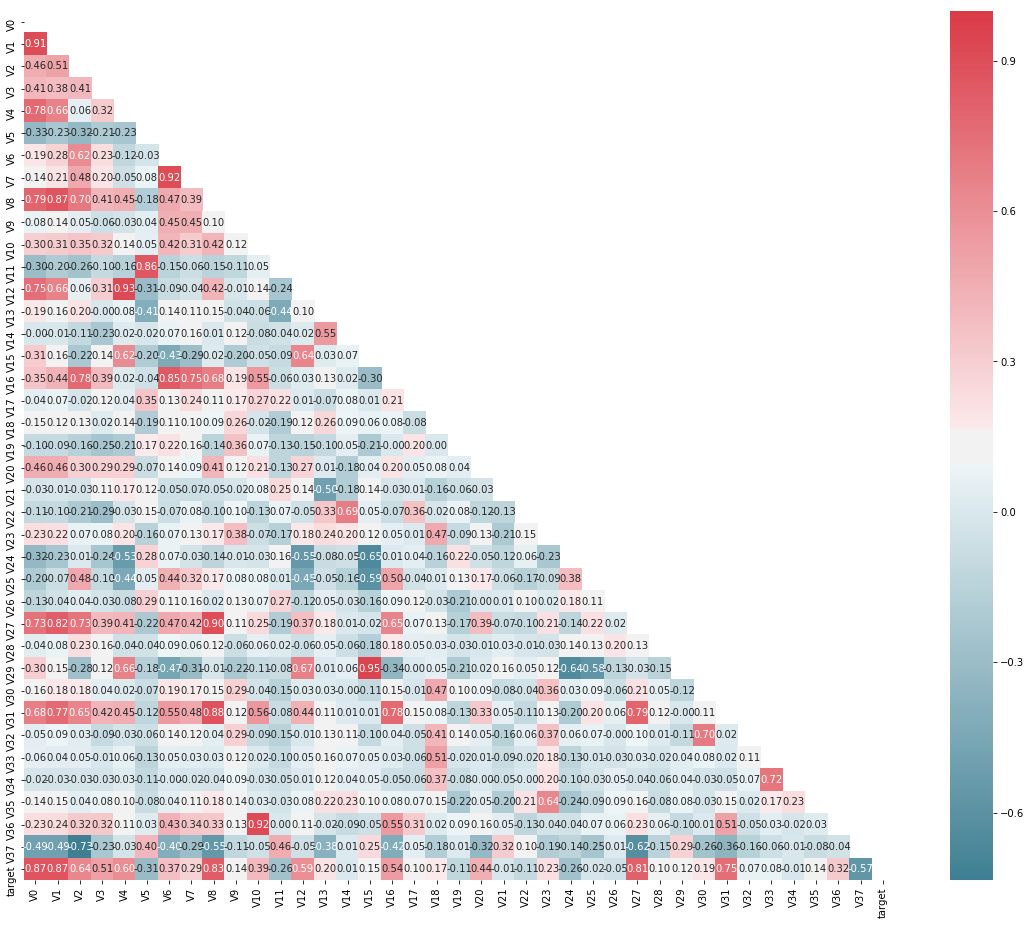

In [64]:
# 找出相关程度
plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
mcorr = train.corr()  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
mask = np.zeros_like(mcorr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型

mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
# 颜色
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  # 热力图（看两两相似度）
plt.show()

### 标准化


In [72]:
data_all[data_all['origin'] == 'test'].describe()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,target
count,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,0.0
mean,-0.184404,-0.083912,-0.051709,-0.034592,-0.293726,-0.144125,-0.170339,-0.082423,0.172829,-0.434762,0.279249,-0.233952,0.032064,0.077170,-0.108471,-0.408566,-0.206871,-0.146463,0.101671,-0.083215,-0.191729,-0.030782,-0.011433,-0.009985,-0.296895,-0.046270,0.195735,-0.019172,-0.274092,-0.173971,-0.266709,0.255114,NaN
std,1.073333,1.076670,1.043967,1.139994,1.039017,0.930072,1.001178,1.060944,0.778954,0.969541,1.199153,0.986066,0.947513,1.110116,1.137409,1.453598,1.064140,0.880593,1.034925,1.126414,1.138454,1.130228,0.989732,0.995213,0.946896,1.040854,0.940599,1.147286,1.054119,1.040101,1.085916,1.014394,NaN
min,-4.814000,-5.488000,-2.583000,-5.505000,-4.087000,-2.376000,-6.060000,-3.583000,-1.904000,-4.283000,-2.861000,-5.552000,-1.339000,-4.732000,-4.891000,-6.874000,-2.435000,-2.413000,-3.276000,-4.507000,-7.698000,-4.057000,-4.627000,-4.789000,-7.477000,-2.608000,-3.346000,-4.921000,-5.649000,-5.625000,-6.059000,-6.784000,NaN
25%,-0.664000,-0.451000,-0.568000,-0.473000,-0.923000,-0.839000,-0.597000,-0.384000,-0.412000,-0.978000,-0.569000,-0.216000,-0.631000,-0.535000,-0.731000,-0.124000,-0.453000,-0.818000,-0.644000,-0.339000,-0.476000,-0.472000,-0.460000,-0.290000,-0.349000,-0.593000,-0.432000,-0.497000,-0.732000,-0.509000,-0.775000,-0.390000,NaN
50%,0.065000,0.195000,0.079000,0.132000,-0.204000,-0.198000,-0.005000,0.075000,0.291000,-0.267000,0.107000,-0.162000,0.093000,-0.026000,0.063000,0.179000,-0.445000,-0.199000,0.220000,0.010000,0.100000,0.155000,-0.040000,0.160000,-0.270000,0.083000,0.152000,0.118000,-0.082000,0.018000,-0.004000,0.401000,NaN
75%,0.549000,0.589000,0.634000,0.583000,0.412000,0.493000,0.464000,0.438000,0.746000,0.278000,0.966000,0.356000,0.800000,0.460000,0.682000,0.317000,-0.434000,0.468000,0.793000,0.447000,0.471000,0.627000,0.419000,0.273000,0.364000,0.651000,0.797000,0.610000,0.457000,0.515000,0.482000,0.904000,NaN
max,2.100000,2.120000,3.118000,4.011000,2.587000,3.073000,2.033000,4.440000,2.196000,1.946000,4.056000,1.354000,1.795000,6.616000,2.472000,0.786000,4.656000,3.022000,2.603000,3.139000,1.428000,2.299000,5.465000,5.110000,1.671000,2.861000,3.021000,4.475000,1.528000,1.394000,2.408000,1.766000,NaN


In [73]:
data_all[data_all['origin'] == 'train'].describe()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,target
count,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000
mean,0.123048,0.056068,0.034319,0.023177,0.195738,0.096146,0.113505,0.055034,-0.114884,0.289720,-0.186226,0.155978,-0.021813,-0.051679,0.072092,0.272407,0.137712,0.097648,-0.067790,0.055477,0.127791,0.020806,0.007801,0.006715,0.197764,0.030658,-0.130330,0.012921,0.182892,0.116155,0.177856,-0.169452,0.126353
std,0.928031,0.941515,0.968272,0.894092,0.922757,1.033048,0.983128,0.953466,1.108859,0.911236,0.788511,0.978757,1.033403,0.915957,0.889771,0.270374,0.929899,1.061200,0.970298,0.901934,0.873028,0.902584,1.006995,1.003291,0.985675,0.970812,1.017196,0.888377,0.918054,0.955116,0.895444,0.953813,0.983966
min,-4.335000,-5.122000,-2.584000,-5.165000,-3.675000,-2.903000,-5.981000,-3.582000,-3.704000,-3.420000,-3.402000,-5.542000,-1.344000,-3.808000,-5.131000,-1.164000,-2.435000,-2.912000,-3.956000,-4.507000,-5.859000,-4.053000,-4.627000,-4.789000,-5.695000,-2.608000,-3.630000,-4.742000,-4.576000,-5.048000,-4.692000,-12.891000,-3.044000
25%,-0.297000,-0.226250,-0.420500,-0.419000,-0.398000,-0.662250,-0.300000,-0.367500,-0.987500,-0.313000,-0.675500,0.097250,-1.191000,-0.557250,-0.452000,0.157750,-0.455000,-0.664000,-0.652250,-0.283000,-0.170250,-0.407250,-0.499000,-0.290000,-0.202500,-0.413000,-0.798250,-0.385000,-0.310000,-0.295000,-0.159000,-0.390000,-0.350250
50%,0.359000,0.272500,0.157000,0.123000,0.289500,-0.000500,0.306000,0.082000,-0.000500,0.386000,-0.156500,0.338000,0.095000,-0.076000,0.075000,0.325000,-0.447000,-0.023000,-0.044500,0.053500,0.299500,0.039000,-0.040000,0.160000,0.364000,0.137000,-0.185500,0.110000,0.388000,0.344000,0.362000,0.042000,0.313000
75%,0.726000,0.599000,0.619250,0.616000,0.864250,0.730000,0.774250,0.513250,0.737250,0.918250,0.304000,0.368250,0.931250,0.356000,0.644250,0.442000,0.730000,0.745250,0.624000,0.488000,0.635000,0.557000,0.462000,0.273000,0.602000,0.644250,0.495250,0.550250,0.831250,0.782250,0.726000,0.042000,0.793250
max,2.121000,1.918000,4.830000,2.657000,2.475000,4.314000,2.861000,4.441000,3.431000,2.828000,3.525000,1.906000,2.423000,7.284000,2.980000,0.925000,4.671000,4.580000,2.457000,2.689000,2.013000,2.395000,5.465000,5.110000,2.324000,5.238000,3.000000,2.689000,1.895000,1.918000,2.245000,1.335000,2.538000


In [74]:
stand = StandardScaler()
data = data_all.iloc[:,:-2]
data2 = stand.fit_transform(data)
data2

In [85]:
cols = data_all.columns
data_all_std = pd.DataFrame(data2,columns=cols[:-2])
data_all_std

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9
0,0.565972,0.015920,-0.939993,-0.073078,0.550083,-0.000048,-1.707156,-0.573113,-0.991209,-0.142971,0.610125,0.356014,0.800200,-0.222870,0.796179,0.167972,-0.449926,0.136001,0.407057,0.109006,-0.615061,0.326836,-4.627276,-4.789544,-5.101136,-2.608111,-3.508388,0.451955,-1.812243,-2.360292,-0.436096,-2.114034
1,0.968009,0.436957,0.188105,-0.134084,1.109140,-0.000048,-0.977080,-0.571113,-0.836206,0.066049,0.588122,0.357014,0.801200,-0.143865,1.057196,0.337989,0.671155,-0.128028,0.566074,0.124008,0.032007,0.599843,-0.843138,0.159981,0.364095,-0.334919,-0.730146,0.193932,-1.566226,-2.360292,0.331988,-2.114034
2,1.013013,0.567968,0.874165,-0.072078,0.767105,-0.212070,-0.618043,-0.564112,-0.558201,0.235065,0.576121,0.355014,0.961187,-0.066860,0.915187,0.325988,1.287200,-0.009015,0.370053,0.361034,0.277033,-0.116176,-0.843138,0.159981,0.364095,0.765175,-0.589134,0.111925,-1.367212,-2.360292,0.395995,-2.114034
3,0.732987,0.367951,0.011090,-0.014073,0.769105,-0.162065,-0.429023,-0.574113,-0.564201,0.283070,0.272086,0.352014,1.435149,0.113152,0.898186,0.276983,1.298201,0.014988,0.165031,0.417040,0.279033,0.602844,-0.843138,-0.065042,0.364095,0.333138,-0.112092,0.598968,-1.200201,-2.086271,0.402996,-2.114034
4,0.683983,0.637974,-0.250933,0.198947,-0.349009,-0.138063,-0.391019,-0.572113,-0.394197,0.260068,0.106068,0.352014,0.881193,0.221159,0.386151,0.331989,1.289200,0.183006,0.209035,1.078113,0.328038,0.417839,-0.843138,-0.215058,0.364095,-0.279914,-0.028085,0.336945,-1.073192,-2.086271,0.313986,-2.114034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,-1.362204,-1.553219,-2.551133,0.395964,0.928122,0.867044,-5.143511,-3.573409,0.106813,-3.096257,-0.087954,-1.538177,-0.629685,-3.072059,-1.119949,-1.674221,0.525145,0.171004,-0.444036,-4.488502,-5.793606,-4.050283,-1.187151,-0.852126,-2.131011,-2.564108,0.596969,0.380949,-4.854453,-5.331512,-4.074495,-3.837771
4809,-2.698326,-3.452386,-2.525131,-1.786233,1.871218,1.135072,-5.774577,-0.965152,0.192815,-3.620307,-0.506002,-1.479171,-0.203719,-3.432082,-2.101015,-1.773231,-0.445926,1.297125,-1.066103,-0.613074,-7.698806,-0.674191,-1.187151,-0.852126,-2.131011,-2.564108,1.215023,-1.385208,-4.927458,-5.103495,-4.393530,-1.683100
4810,-2.615319,-3.564396,-2.529131,-1.151175,1.976228,0.504005,-4.752471,-1.568211,0.300817,-3.402286,0.109068,-1.085132,1.057179,-2.409015,0.477157,-1.585212,-0.446926,0.552045,-0.422033,0.125008,-6.111639,0.274835,-1.851175,-1.548200,-1.536986,-2.544106,1.612058,-1.272198,-4.223410,-4.315437,-5.196618,-3.406837
4811,-2.661323,-3.646403,-2.560134,-1.512208,1.520182,0.205974,-4.200414,-1.282183,-0.036190,-3.271274,-1.015059,-1.084132,0.800200,-2.339010,0.050129,-1.410193,-0.446926,0.318020,-0.699063,1.086114,-5.268550,0.682846,-1.645168,-1.471192,-1.536986,-2.549106,1.431042,-1.270198,-3.716375,-3.809399,-4.735567,-2.975902


In [84]:
data_all.index = np.arange(4813)
data_all

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,origin,target
0,0.566,0.016,-0.940,-0.073,0.550,0.000,-1.707,-0.573,-0.991,-0.143,0.610,0.356,0.800,-0.223,0.796,0.168,-0.450,0.136,0.407,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.452,-1.812,-2.360,-0.436,-2.114,train,0.175
1,0.968,0.437,0.188,-0.134,1.109,0.000,-0.977,-0.571,-0.836,0.066,0.588,0.357,0.801,-0.144,1.057,0.338,0.671,-0.128,0.566,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.194,-1.566,-2.360,0.332,-2.114,train,0.676
2,1.013,0.568,0.874,-0.072,0.767,-0.212,-0.618,-0.564,-0.558,0.235,0.576,0.355,0.961,-0.067,0.915,0.326,1.287,-0.009,0.370,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.112,-1.367,-2.360,0.396,-2.114,train,0.633
3,0.733,0.368,0.011,-0.014,0.769,-0.162,-0.429,-0.574,-0.564,0.283,0.272,0.352,1.435,0.113,0.898,0.277,1.298,0.015,0.165,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.599,-1.200,-2.086,0.403,-2.114,train,0.206
4,0.684,0.638,-0.251,0.199,-0.349,-0.138,-0.391,-0.572,-0.394,0.260,0.106,0.352,0.881,0.221,0.386,0.332,1.289,0.183,0.209,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.337,-1.073,-2.086,0.314,-2.114,train,0.384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,-1.362,-1.553,-2.551,0.396,0.928,0.867,-5.143,-3.573,0.107,-3.096,-0.088,-1.538,-0.630,-3.072,-1.120,-1.674,0.525,0.171,-0.444,-4.488,-5.793,-4.050,-1.187,-0.852,-2.131,-2.564,0.597,0.381,-4.854,-5.331,-4.074,-3.838,test,NaN
4809,-2.698,-3.452,-2.525,-1.786,1.871,1.135,-5.774,-0.965,0.193,-3.620,-0.506,-1.479,-0.204,-3.432,-2.101,-1.773,-0.446,1.297,-1.066,-0.613,-7.698,-0.674,-1.187,-0.852,-2.131,-2.564,1.215,-1.385,-4.927,-5.103,-4.393,-1.683,test,NaN
4810,-2.615,-3.564,-2.529,-1.151,1.976,0.504,-4.752,-1.568,0.301,-3.402,0.109,-1.085,1.057,-2.409,0.477,-1.585,-0.447,0.552,-0.422,0.125,-6.111,0.275,-1.851,-1.548,-1.537,-2.544,1.612,-1.272,-4.223,-4.315,-5.196,-3.407,test,NaN
4811,-2.661,-3.646,-2.560,-1.512,1.520,0.206,-4.200,-1.282,-0.036,-3.271,-1.015,-1.084,0.800,-2.339,0.050,-1.410,-0.447,0.318,-0.699,1.086,-5.268,0.683,-1.645,-1.471,-1.537,-2.549,1.431,-1.270,-3.716,-3.809,-4.735,-2.976,test,NaN


In [86]:
data_all_std = pd.merge(data_all_std,data_all.iloc[:,-2:],right_index=True,left_index=True)
data_all_std.head()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,origin,target
0,0.565972,0.015920,-0.939993,-0.073078,0.550083,-0.000048,-1.707156,-0.573113,-0.991209,-0.142971,0.610125,0.356014,0.800200,-0.222870,0.796179,0.167972,-0.449926,0.136001,0.407057,0.109006,-0.615061,0.326836,-4.627276,-4.789544,-5.101136,-2.608111,-3.508388,0.451955,-1.812243,-2.360292,-0.436096,-2.114034,train,0.175
1,0.968009,0.436957,0.188105,-0.134084,1.109140,-0.000048,-0.977080,-0.571113,-0.836206,0.066049,0.588122,0.357014,0.801200,-0.143865,1.057196,0.337989,0.671155,-0.128028,0.566074,0.124008,0.032007,0.599843,-0.843138,0.159981,0.364095,-0.334919,-0.730146,0.193932,-1.566226,-2.360292,0.331988,-2.114034,train,0.676
2,1.013013,0.567968,0.874165,-0.072078,0.767105,-0.212070,-0.618043,-0.564112,-0.558201,0.235065,0.576121,0.355014,0.961187,-0.066860,0.915187,0.325988,1.287200,-0.009015,0.370053,0.361034,0.277033,-0.116176,-0.843138,0.159981,0.364095,0.765175,-0.589134,0.111925,-1.367212,-2.360292,0.395995,-2.114034,train,0.633
3,0.732987,0.367951,0.011090,-0.014073,0.769105,-0.162065,-0.429023,-0.574113,-0.564201,0.283070,0.272086,0.352014,1.435149,0.113152,0.898186,0.276983,1.298201,0.014988,0.165031,0.417040,0.279033,0.602844,-0.843138,-0.065042,0.364095,0.333138,-0.112092,0.598968,-1.200201,-2.086271,0.402996,-2.114034,train,0.206
4,0.683983,0.637974,-0.250933,0.198947,-0.349009,-0.138063,-0.391019,-0.572113,-0.394197,0.260068,0.106068,0.352014,0.881193,0.221159,0.386151,0.331989,1.289200,0.183006,0.209035,1.078113,0.328038,0.417839,-0.843138,-0.215058,0.364095,-0.279914,-0.028085,0.336945,-1.073192,-2.086271,0.313986,-2.114034,train,0.384


In [87]:
data_all_std.describe()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,target
count,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4813.000000,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4813.000000,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4813.000000,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,4.813000e+03,2888.000000
mean,-2.362078e-17,2.362078e-17,-2.952598e-18,-2.362078e-17,0.000000,1.181039e-17,-2.362078e-17,3.543118e-17,-4.724157e-17,0.000000,2.362078e-17,2.362078e-17,2.362078e-17,2.362078e-17,3.543118e-17,0.000000,2.362078e-17,-2.362078e-17,-4.724157e-17,-1.181039e-17,3.543118e-17,2.066819e-17,-1.181039e-17,-8.857794e-18,2.362078e-17,5.905196e-18,-1.181039e-17,3.543118e-17,1.181039e-17,-1.181039e-17,4.724157e-17,-4.724157e-17,0.126353
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,0.983966
min,-4.814520e+00,-5.488566e+00,-2.584136e+00,-5.505569e+00,-4.087390,-2.903355e+00,-6.060606e+00,-3.583410e+00,-3.704265e+00,-4.283371,-3.402329e+00,-5.552583e+00,-1.343627e+00,-4.732168e+00,-5.131218e+00,-6.874765,-2.435070e+00,-2.912326e+00,-3.956418e+00,-4.507504e+00,-7.698806e+00,-4.057283e+00,-4.627276e+00,-4.789544e+00,-7.477236e+00,-2.608111e+00,-3.630399e+00,-4.921523e+00,-5.649508e+00,-5.625534e+00,-6.059712e+00,-1.288939e+01,-3.044000
25%,-4.681226e-01,-3.191100e-01,-4.759526e-01,-4.341107e-01,-0.617036,-7.451267e-01,-4.450251e-01,-3.790941e-01,-7.472045e-01,-0.625018,-6.390166e-01,-1.870409e-01,-1.190640e+00,-5.518919e-01,-5.359103e-01,0.055960,-4.539264e-01,-7.210913e-01,-6.510581e-01,-3.010393e-01,-3.000276e-01,-4.281845e-01,-4.991259e-01,-2.900663e-01,-3.489356e-01,-4.849312e-01,-6.661407e-01,-4.281231e-01,-4.941518e-01,-3.681437e-01,-4.290956e-01,-3.902971e-01,-0.350250
50%,2.449426e-01,2.369390e-01,1.331003e-01,1.249398e-01,0.103038,-7.805624e-02,1.870403e-01,7.795097e-02,1.508138e-01,0.105053,-6.595178e-02,3.310114e-01,9.425669e-02,-5.985935e-02,7.013018e-02,0.269982,-4.459258e-01,-9.702433e-02,7.302061e-02,3.799817e-02,2.170268e-01,9.182964e-02,-4.010929e-02,1.599815e-01,3.640945e-01,1.151197e-01,-4.308645e-02,1.139252e-01,1.908956e-01,1.978983e-01,2.309767e-01,4.163690e-02,0.313000
75%,6.659811e-01,5.949706e-01,6.261431e-01,6.039831e-01,0.718100,6.330189e-01,6.600893e-01,4.429870e-01,7.418258e-01,0.698110,4.961118e-01,3.600143e-01,8.211981e-01,4.061715e-01,6.571694e-01,0.398996,5.001429e-01,6.230529e-01,7.040892e-01,4.690458e-01,5.780648e-01,5.868431e-01,4.189074e-01,2.729934e-01,3.640945e-01,6.471648e-01,6.469737e-01,5.759663e-01,7.049312e-01,6.839344e-01,6.370211e-01,9.035053e-01,0.793250
max,2.121114e+00,2.120105e+00,4.830508e+00,4.011291e+00,2.587291,4.314408e+00,2.861317e+00,4.441381e+00,3.430881e+00,2.828316,4.056514e+00,1.906171e+00,2.423069e+00,7.284627e+00,2.980325e+00,0.925051,4.671446e+00,4.580477e+00,2.603296e+00,3.139341e+00,2.013216e+00,2.394892e+00,5.465091e+00,5.110507e+00,2.324177e+00,5.238554e+00,3.021181e+00,4.475314e+00,1.895013e+00,1.918026e+00,2.408215e+00,1.765374e+00,2.538000


### 使用不同的算法进行训练

In [90]:
# 异常值
from sklearn.linear_model import RidgeCV

In [91]:
data_all_std.head()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,origin,target
0,0.565972,0.015920,-0.939993,-0.073078,0.550083,-0.000048,-1.707156,-0.573113,-0.991209,-0.142971,0.610125,0.356014,0.800200,-0.222870,0.796179,0.167972,-0.449926,0.136001,0.407057,0.109006,-0.615061,0.326836,-4.627276,-4.789544,-5.101136,-2.608111,-3.508388,0.451955,-1.812243,-2.360292,-0.436096,-2.114034,train,0.175
1,0.968009,0.436957,0.188105,-0.134084,1.109140,-0.000048,-0.977080,-0.571113,-0.836206,0.066049,0.588122,0.357014,0.801200,-0.143865,1.057196,0.337989,0.671155,-0.128028,0.566074,0.124008,0.032007,0.599843,-0.843138,0.159981,0.364095,-0.334919,-0.730146,0.193932,-1.566226,-2.360292,0.331988,-2.114034,train,0.676
2,1.013013,0.567968,0.874165,-0.072078,0.767105,-0.212070,-0.618043,-0.564112,-0.558201,0.235065,0.576121,0.355014,0.961187,-0.066860,0.915187,0.325988,1.287200,-0.009015,0.370053,0.361034,0.277033,-0.116176,-0.843138,0.159981,0.364095,0.765175,-0.589134,0.111925,-1.367212,-2.360292,0.395995,-2.114034,train,0.633
3,0.732987,0.367951,0.011090,-0.014073,0.769105,-0.162065,-0.429023,-0.574113,-0.564201,0.283070,0.272086,0.352014,1.435149,0.113152,0.898186,0.276983,1.298201,0.014988,0.165031,0.417040,0.279033,0.602844,-0.843138,-0.065042,0.364095,0.333138,-0.112092,0.598968,-1.200201,-2.086271,0.402996,-2.114034,train,0.206
4,0.683983,0.637974,-0.250933,0.198947,-0.349009,-0.138063,-0.391019,-0.572113,-0.394197,0.260068,0.106068,0.352014,0.881193,0.221159,0.386151,0.331989,1.289200,0.183006,0.209035,1.078113,0.328038,0.417839,-0.843138,-0.215058,0.364095,-0.279914,-0.028085,0.336945,-1.073192,-2.086271,0.313986,-2.114034,train,0.384


In [205]:
ridge = RidgeCV(alphas=[0.0001,0.001,0.01,0.1,0.2,0.5,1,2,3,4,5,10,20,30,50])

cond = data_all_std['origin'] == 'train'

X_train = data_all_std[cond].iloc[:,:-2]
# 真实值
y_train = data_all_std[cond]['target']
# 算法拟合数据和目标值的时候，不可能100%拟合
ridge.fit(X_train,y_train)
# 预测，预测值肯定会和真实值有一定的偏差，偏差特别大，当成异常值
y_ = ridge.predict(X_train)

$$3\sigma$$

In [206]:
cond = abs((y_train - y_ )) > y_train.std()*0.8
cond.sum()

10

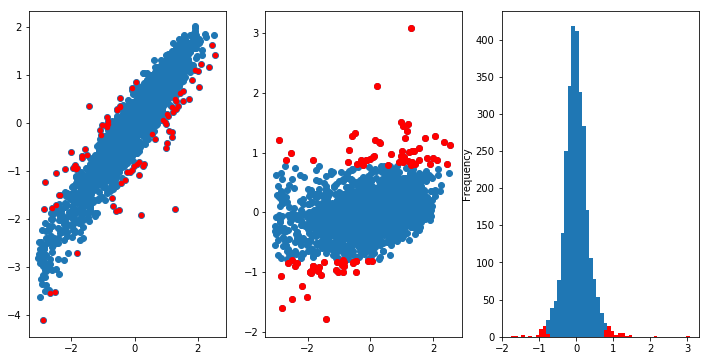

In [132]:
# 画图
plt.figure(figsize=(12,6))
axes = plt.subplot(1,3,1)
axes.scatter(y_train,y_)
axes.scatter(y_train[cond],y_[cond],c = 'red',s = 20)

axes = plt.subplot(1,3,2)
axes.scatter(y_train,y_train - y_)
axes.scatter(y_train[cond],(y_train - y_)[cond],c = 'red')

axes = plt.subplot(1,3,3)
# _ = axes.hist(y_train,bins = 50)
(y_train - y_).plot.hist(bins = 50,ax = axes)
(y_train - y_).loc[cond].plot.hist(bins = 50,ax = axes,color = 'r')

In [134]:
data_all_std

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,origin,target
0,0.565972,0.015920,-0.939993,-0.073078,0.550083,-0.000048,-1.707156,-0.573113,-0.991209,-0.142971,0.610125,0.356014,0.800200,-0.222870,0.796179,0.167972,-0.449926,0.136001,0.407057,0.109006,-0.615061,0.326836,-4.627276,-4.789544,-5.101136,-2.608111,-3.508388,0.451955,-1.812243,-2.360292,-0.436096,-2.114034,train,0.175
1,0.968009,0.436957,0.188105,-0.134084,1.109140,-0.000048,-0.977080,-0.571113,-0.836206,0.066049,0.588122,0.357014,0.801200,-0.143865,1.057196,0.337989,0.671155,-0.128028,0.566074,0.124008,0.032007,0.599843,-0.843138,0.159981,0.364095,-0.334919,-0.730146,0.193932,-1.566226,-2.360292,0.331988,-2.114034,train,0.676
2,1.013013,0.567968,0.874165,-0.072078,0.767105,-0.212070,-0.618043,-0.564112,-0.558201,0.235065,0.576121,0.355014,0.961187,-0.066860,0.915187,0.325988,1.287200,-0.009015,0.370053,0.361034,0.277033,-0.116176,-0.843138,0.159981,0.364095,0.765175,-0.589134,0.111925,-1.367212,-2.360292,0.395995,-2.114034,train,0.633
3,0.732987,0.367951,0.011090,-0.014073,0.769105,-0.162065,-0.429023,-0.574113,-0.564201,0.283070,0.272086,0.352014,1.435149,0.113152,0.898186,0.276983,1.298201,0.014988,0.165031,0.417040,0.279033,0.602844,-0.843138,-0.065042,0.364095,0.333138,-0.112092,0.598968,-1.200201,-2.086271,0.402996,-2.114034,train,0.206
4,0.683983,0.637974,-0.250933,0.198947,-0.349009,-0.138063,-0.391019,-0.572113,-0.394197,0.260068,0.106068,0.352014,0.881193,0.221159,0.386151,0.331989,1.289200,0.183006,0.209035,1.078113,0.328038,0.417839,-0.843138,-0.215058,0.364095,-0.279914,-0.028085,0.336945,-1.073192,-2.086271,0.313986,-2.114034,train,0.384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,-1.362204,-1.553219,-2.551133,0.395964,0.928122,0.867044,-5.143511,-3.573409,0.106813,-3.096257,-0.087954,-1.538177,-0.629685,-3.072059,-1.119949,-1.674221,0.525145,0.171004,-0.444036,-4.488502,-5.793606,-4.050283,-1.187151,-0.852126,-2.131011,-2.564108,0.596969,0.380949,-4.854453,-5.331512,-4.074495,-3.837771,test,NaN
4809,-2.698326,-3.452386,-2.525131,-1.786233,1.871218,1.135072,-5.774577,-0.965152,0.192815,-3.620307,-0.506002,-1.479171,-0.203719,-3.432082,-2.101015,-1.773231,-0.445926,1.297125,-1.066103,-0.613074,-7.698806,-0.674191,-1.187151,-0.852126,-2.131011,-2.564108,1.215023,-1.385208,-4.927458,-5.103495,-4.393530,-1.683100,test,NaN
4810,-2.615319,-3.564396,-2.529131,-1.151175,1.976228,0.504005,-4.752471,-1.568211,0.300817,-3.402286,0.109068,-1.085132,1.057179,-2.409015,0.477157,-1.585212,-0.446926,0.552045,-0.422033,0.125008,-6.111639,0.274835,-1.851175,-1.548200,-1.536986,-2.544106,1.612058,-1.272198,-4.223410,-4.315437,-5.196618,-3.406837,test,NaN
4811,-2.661323,-3.646403,-2.560134,-1.512208,1.520182,0.205974,-4.200414,-1.282183,-0.036190,-3.271274,-1.015059,-1.084132,0.800200,-2.339010,0.050129,-1.410193,-0.446926,0.318020,-0.699063,1.086114,-5.268550,0.682846,-1.645168,-1.471192,-1.536986,-2.549106,1.431042,-1.270198,-3.716375,-3.809399,-4.735567,-2.975902,test,NaN


In [138]:
# 将异常值点过滤
drop_index = cond[cond].index
print(data_all_std.shape)
data_all_std.drop(drop_index,axis = 0,inplace=True)
data_all_std.shape

(4813, 34)


(4725, 34)

In [144]:
def detect_model(etsimators,data):
    for key,estimator in estimators.items():
        estimator.fit(data[0],data[2])
        y_ = estimator.predict(data[1])
        mse = mean_squared_error(data[3],y_)
        print('-------------------mse%s'%(key),mse)
        r2 = estimator.score(data[1],data[3])
        print('+++++++++++++++++++r2_score%s'%(key),r2)
        print('\n')

In [141]:
cond = data_all_std['origin'] == 'train'
X = data_all_std[cond].iloc[:,:-2]
y = data_all_std[cond]['target']
data = train_test_split(X,y,test_size = 0.2)

In [142]:
estimators = {}
estimators['knn'] = KNeighborsRegressor()
estimators['linear'] = LinearRegression()
estimators['ridge'] = Ridge()
estimators['lasso'] = Lasso()
estimators['elasticnet'] = ElasticNet()
estimators['forest'] = RandomForestRegressor()
estimators['gbdt'] = GradientBoostingRegressor()
estimators['ada'] = AdaBoostRegressor()
estimators['extreme'] = ExtraTreesRegressor()
estimators['svm_rbf'] = SVR(kernel='rbf')
estimators['svm_poly'] = SVR(kernel='poly')
estimators['light'] = LGBMRegressor()
estimators['xgb'] = XGBRegressor()

In [145]:
# 对于我们的测试数据而言：KNN、Lasso、ElasticNet、SVM_poly
detect_model(estimators,data)

-------------------mseknn 0.15412721785714284
+++++++++++++++++++r2_scoreknn 0.8442194676457737


-------------------mselinear 0.07485336723348453
+++++++++++++++++++r2_scorelinear 0.9243436846634923


-------------------mseridge 0.07509670062707155
+++++++++++++++++++r2_scoreridge 0.9240977410454893


-------------------mselasso 0.9903481759765626
+++++++++++++++++++r2_scorelasso -0.0009715883709899841


-------------------mseelasticnet 0.5900633847971676
+++++++++++++++++++r2_scoreelasticnet 0.40360703654796115


-------------------mseforest 0.09673654726785713
+++++++++++++++++++r2_scoreforest 0.9022257649167177


-------------------msegbdt 0.07919785725309644
+++++++++++++++++++r2_scoregbdt 0.9199525915297015


-------------------mseada 0.10102517946858308
+++++++++++++++++++r2_scoreada 0.8978911287856756


-------------------mseextreme 0.09239334717857144
+++++++++++++++++++r2_scoreextreme 0.906615554283168


-------------------msesvm_rbf 0.08613705162351616
+++++++++++++++++++r2_

In [172]:
estimators = {}
# estimators['linear'] = LinearRegression()
# estimators['ridge'] = Ridge()
# estimators['lasso'] = Lasso()
estimators['forest'] = RandomForestRegressor()
estimators['gbdt'] = GradientBoostingRegressor()
estimators['ada'] = AdaBoostRegressor()
estimators['extreme'] = ExtraTreesRegressor()
estimators['svm_rbf'] = SVR(kernel='rbf')
estimators['light'] = LGBMRegressor()
estimators['xgb'] = XGBRegressor()

In [169]:
cond = data_all_std['origin'] == 'train'

X_train = data_all_std[cond].iloc[:,:-2]
y_train = data_all_std[cond]['target']

cond = data_all_std['origin'] == 'test'
X_test = data_all_std[cond].iloc[:,:-2]

In [153]:
# 一个算法预测结果，将结果合并
y_pred = []
for key,model in estimators.items():
    model.fit(X_train,y_train)
    y_ = model.predict(X_test)
    y_pred.append(y_)

y_ = np.mean(y_pred,axis = 0)

In [154]:
pd.Series(y_).to_csv('./ensemble2.txt',index =False)

In [155]:
# 预测的结果作为新特征，让我们的算法学习，寻找数据和目标值之间的关系
# y_ 预测值，和真实值之间差距，将预测值当成新的特征，让我们算法进行再学习
for key,model in estimators.items():
    model.fit(X_train,y_train)
    y_ = model.predict(X_train)
    X_train[key] = y_
    y_ = model.predict(X_test)
    X_test[key] = y_

In [173]:
# 一个算法预测结果，将结果合并
y_pred = []
for key,model in estimators.items():
    model.fit(X_train,y_train)
    y_ = model.predict(X_test)
    y_pred.append(y_)

y_ = np.mean(y_pred,axis = 0)

In [174]:
pd.Series(y_).to_csv('./ensemble5.txt',index =False)

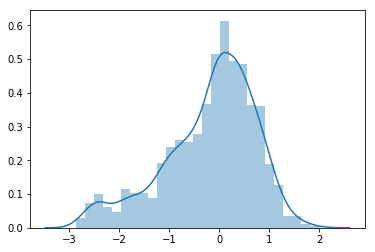

In [161]:
sns.distplot(y_)

In [162]:
y_.mean()

-0.18893485366369206

In [165]:
y_.shape

(1925,)

In [166]:
y_ += np.random.randn(1925)*0.1

In [167]:
pd.Series(y_).to_csv('./ensemble4.txt',index =False)

### 对数据进行归一化

In [176]:
# 4个测试和训练特征分布不均匀，2个相关性系数小的特征
data_all.head()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,origin,target
0,0.566,0.016,-0.940,-0.073,0.550,0.000,-1.707,-0.573,-0.991,-0.143,0.610,0.356,0.800,-0.223,0.796,0.168,-0.450,0.136,0.407,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.452,-1.812,-2.360,-0.436,-2.114,train,0.175
1,0.968,0.437,0.188,-0.134,1.109,0.000,-0.977,-0.571,-0.836,0.066,0.588,0.357,0.801,-0.144,1.057,0.338,0.671,-0.128,0.566,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.194,-1.566,-2.360,0.332,-2.114,train,0.676
2,1.013,0.568,0.874,-0.072,0.767,-0.212,-0.618,-0.564,-0.558,0.235,0.576,0.355,0.961,-0.067,0.915,0.326,1.287,-0.009,0.370,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.112,-1.367,-2.360,0.396,-2.114,train,0.633
3,0.733,0.368,0.011,-0.014,0.769,-0.162,-0.429,-0.574,-0.564,0.283,0.272,0.352,1.435,0.113,0.898,0.277,1.298,0.015,0.165,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.599,-1.200,-2.086,0.403,-2.114,train,0.206
4,0.684,0.638,-0.251,0.199,-0.349,-0.138,-0.391,-0.572,-0.394,0.260,0.106,0.352,0.881,0.221,0.386,0.332,1.289,0.183,0.209,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.337,-1.073,-2.086,0.314,-2.114,train,0.384


In [177]:
data = data_all.iloc[:,:-2]

minmaxscaler = MinMaxScaler()

data3 = minmaxscaler.fit_transform(data)
data3

array([[0.77577505, 0.723449  , 0.22174265, ..., 0.43285165, 0.66410771,
        0.73528007],
       [0.83374189, 0.77878549, 0.37388724, ..., 0.43285165, 0.7548128 ,
        0.73528007],
       [0.84023071, 0.79600421, 0.46641489, ..., 0.43285165, 0.76237156,
        0.73528007],
       ...,
       [0.31708724, 0.25289169, 0.0074184 , ..., 0.17367095, 0.10192512,
        0.64706284],
       [0.31045422, 0.24211356, 0.00323712, ..., 0.24075302, 0.1563718 ,
        0.67646858],
       [0.35948089, 0.32216088, 0.35608309, ..., 0.24897256, 0.19971655,
        0.67646858]])

In [178]:
# 归一化的数据
data_all_norm = pd.DataFrame(data3,columns=data_all.columns[:-2])
data_all_norm

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9
0,0.775775,0.723449,0.221743,0.570828,0.694786,0.402245,0.487950,0.375125,0.380238,0.582197,0.537946,0.792169,0.569153,0.375250,0.730736,0.902936,0.279341,0.406834,0.665193,0.603714,0.729379,0.679479,0.000000,0.000000,0.242424,0.000000,0.018343,0.571839,0.508616,0.432852,0.664108,0.735280
1,0.833742,0.778785,0.373887,0.564418,0.778544,0.402245,0.569779,0.375374,0.401962,0.611588,0.534996,0.792304,0.569419,0.381824,0.762915,0.924734,0.437095,0.371596,0.689434,0.605676,0.796005,0.721792,0.374950,0.499949,0.800020,0.289702,0.436025,0.544381,0.541225,0.432852,0.754813,0.735280
2,0.840231,0.796004,0.466415,0.570933,0.727300,0.372870,0.610021,0.376246,0.440925,0.635354,0.533387,0.792035,0.611893,0.388232,0.745407,0.923195,0.523783,0.387480,0.659552,0.636673,0.821234,0.610818,0.374950,0.499949,0.800020,0.429901,0.457224,0.535653,0.567603,0.432852,0.762372,0.735280
3,0.799856,0.769716,0.350013,0.577028,0.727600,0.379798,0.631207,0.375000,0.440084,0.642104,0.492625,0.791633,0.737722,0.403212,0.743312,0.916912,0.525331,0.390683,0.628297,0.643997,0.821440,0.722257,0.374950,0.477220,0.800020,0.374841,0.528943,0.587484,0.589740,0.469177,0.763198,0.735280
4,0.792790,0.805205,0.314675,0.599412,0.560084,0.383123,0.635467,0.375249,0.463910,0.638869,0.470367,0.791633,0.590656,0.412200,0.680187,0.923965,0.524064,0.413107,0.635005,0.730447,0.826485,0.693583,0.374950,0.462067,0.800020,0.296712,0.541573,0.559600,0.606575,0.469177,0.752687,0.735280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,0.497765,0.517219,0.004451,0.620113,0.751423,0.522378,0.102791,0.001246,0.534128,0.166924,0.444355,0.538214,0.189541,0.138149,0.494514,0.666752,0.416549,0.411506,0.535447,0.002485,0.196169,0.001085,0.340864,0.397717,0.545455,0.005608,0.635544,0.564283,0.105382,0.038977,0.234440,0.617657
4809,0.305119,0.267613,0.007958,0.390815,0.892718,0.559512,0.032059,0.326271,0.546181,0.093236,0.388308,0.546125,0.302628,0.108189,0.373567,0.654058,0.279904,0.561799,0.440616,0.509286,0.000000,0.524334,0.340864,0.397717,0.545455,0.005608,0.728462,0.376330,0.095705,0.069203,0.196764,0.764686
4810,0.317087,0.252892,0.007418,0.457545,0.908451,0.472080,0.146620,0.251122,0.561317,0.123893,0.470770,0.598954,0.637377,0.193326,0.691407,0.678164,0.279764,0.462360,0.538802,0.605807,0.163423,0.671420,0.275069,0.327407,0.606061,0.008157,0.788152,0.388357,0.189024,0.173671,0.101925,0.647063
4811,0.310454,0.242114,0.003237,0.419609,0.840126,0.430788,0.208497,0.286765,0.514085,0.142315,0.320059,0.599088,0.569153,0.199151,0.638762,0.700603,0.279764,0.431127,0.496570,0.731494,0.250232,0.734656,0.295482,0.335185,0.606061,0.007520,0.760938,0.388570,0.256230,0.240753,0.156372,0.676469


In [180]:
data_all_norm = pd.merge(data_all_norm,data_all.iloc[:,-2:],left_index= True,right_index=True)

In [181]:
data_all_norm.describe()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,V20,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V4,V6,V7,V8,V9,target
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,2888.000000
mean,0.694172,0.721357,0.348518,0.578507,0.612372,0.402251,0.679294,0.446542,0.519158,0.602300,0.456147,0.744438,0.356712,0.393796,0.632582,0.881401,0.342653,0.388683,0.603139,0.589459,0.792709,0.628824,0.458493,0.483790,0.762873,0.332385,0.545795,0.523743,0.748823,0.745740,0.715607,0.879536,0.126353
std,0.144198,0.131443,0.134882,0.105088,0.149835,0.138561,0.112095,0.124627,0.140166,0.140628,0.134083,0.134085,0.265512,0.083226,0.123294,0.128221,0.140731,0.133475,0.152462,0.130786,0.102976,0.155003,0.099095,0.101020,0.102037,0.127456,0.150356,0.106430,0.132560,0.132577,0.118105,0.068244,0.983966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.044000
25%,0.626676,0.679416,0.284327,0.532892,0.519928,0.299016,0.629414,0.399302,0.414436,0.514414,0.370475,0.719362,0.040616,0.347870,0.566515,0.888575,0.278778,0.292445,0.503888,0.550092,0.761816,0.562461,0.409037,0.454490,0.727273,0.270584,0.445647,0.478182,0.683324,0.696938,0.664934,0.852903,-0.350250
50%,0.729488,0.752497,0.366469,0.591635,0.627809,0.391437,0.700258,0.456256,0.540294,0.617072,0.447305,0.788817,0.381736,0.388815,0.641228,0.916015,0.279904,0.375734,0.614270,0.594428,0.815055,0.643056,0.454518,0.499949,0.800020,0.347056,0.539317,0.535866,0.774125,0.771974,0.742884,0.882377,0.313000
75%,0.790195,0.799553,0.432965,0.641971,0.719958,0.489954,0.753279,0.501745,0.623125,0.700464,0.522660,0.792706,0.574728,0.427597,0.713599,0.932555,0.413031,0.471837,0.710474,0.650798,0.852229,0.719777,0.500000,0.511365,0.800020,0.414861,0.643061,0.585036,0.842259,0.836405,0.790835,0.941189,0.793250
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.538000


In [186]:
frows

31

In [194]:
def scale_minmax(data):
    return (data - data.min())/(data.max() - data.min())

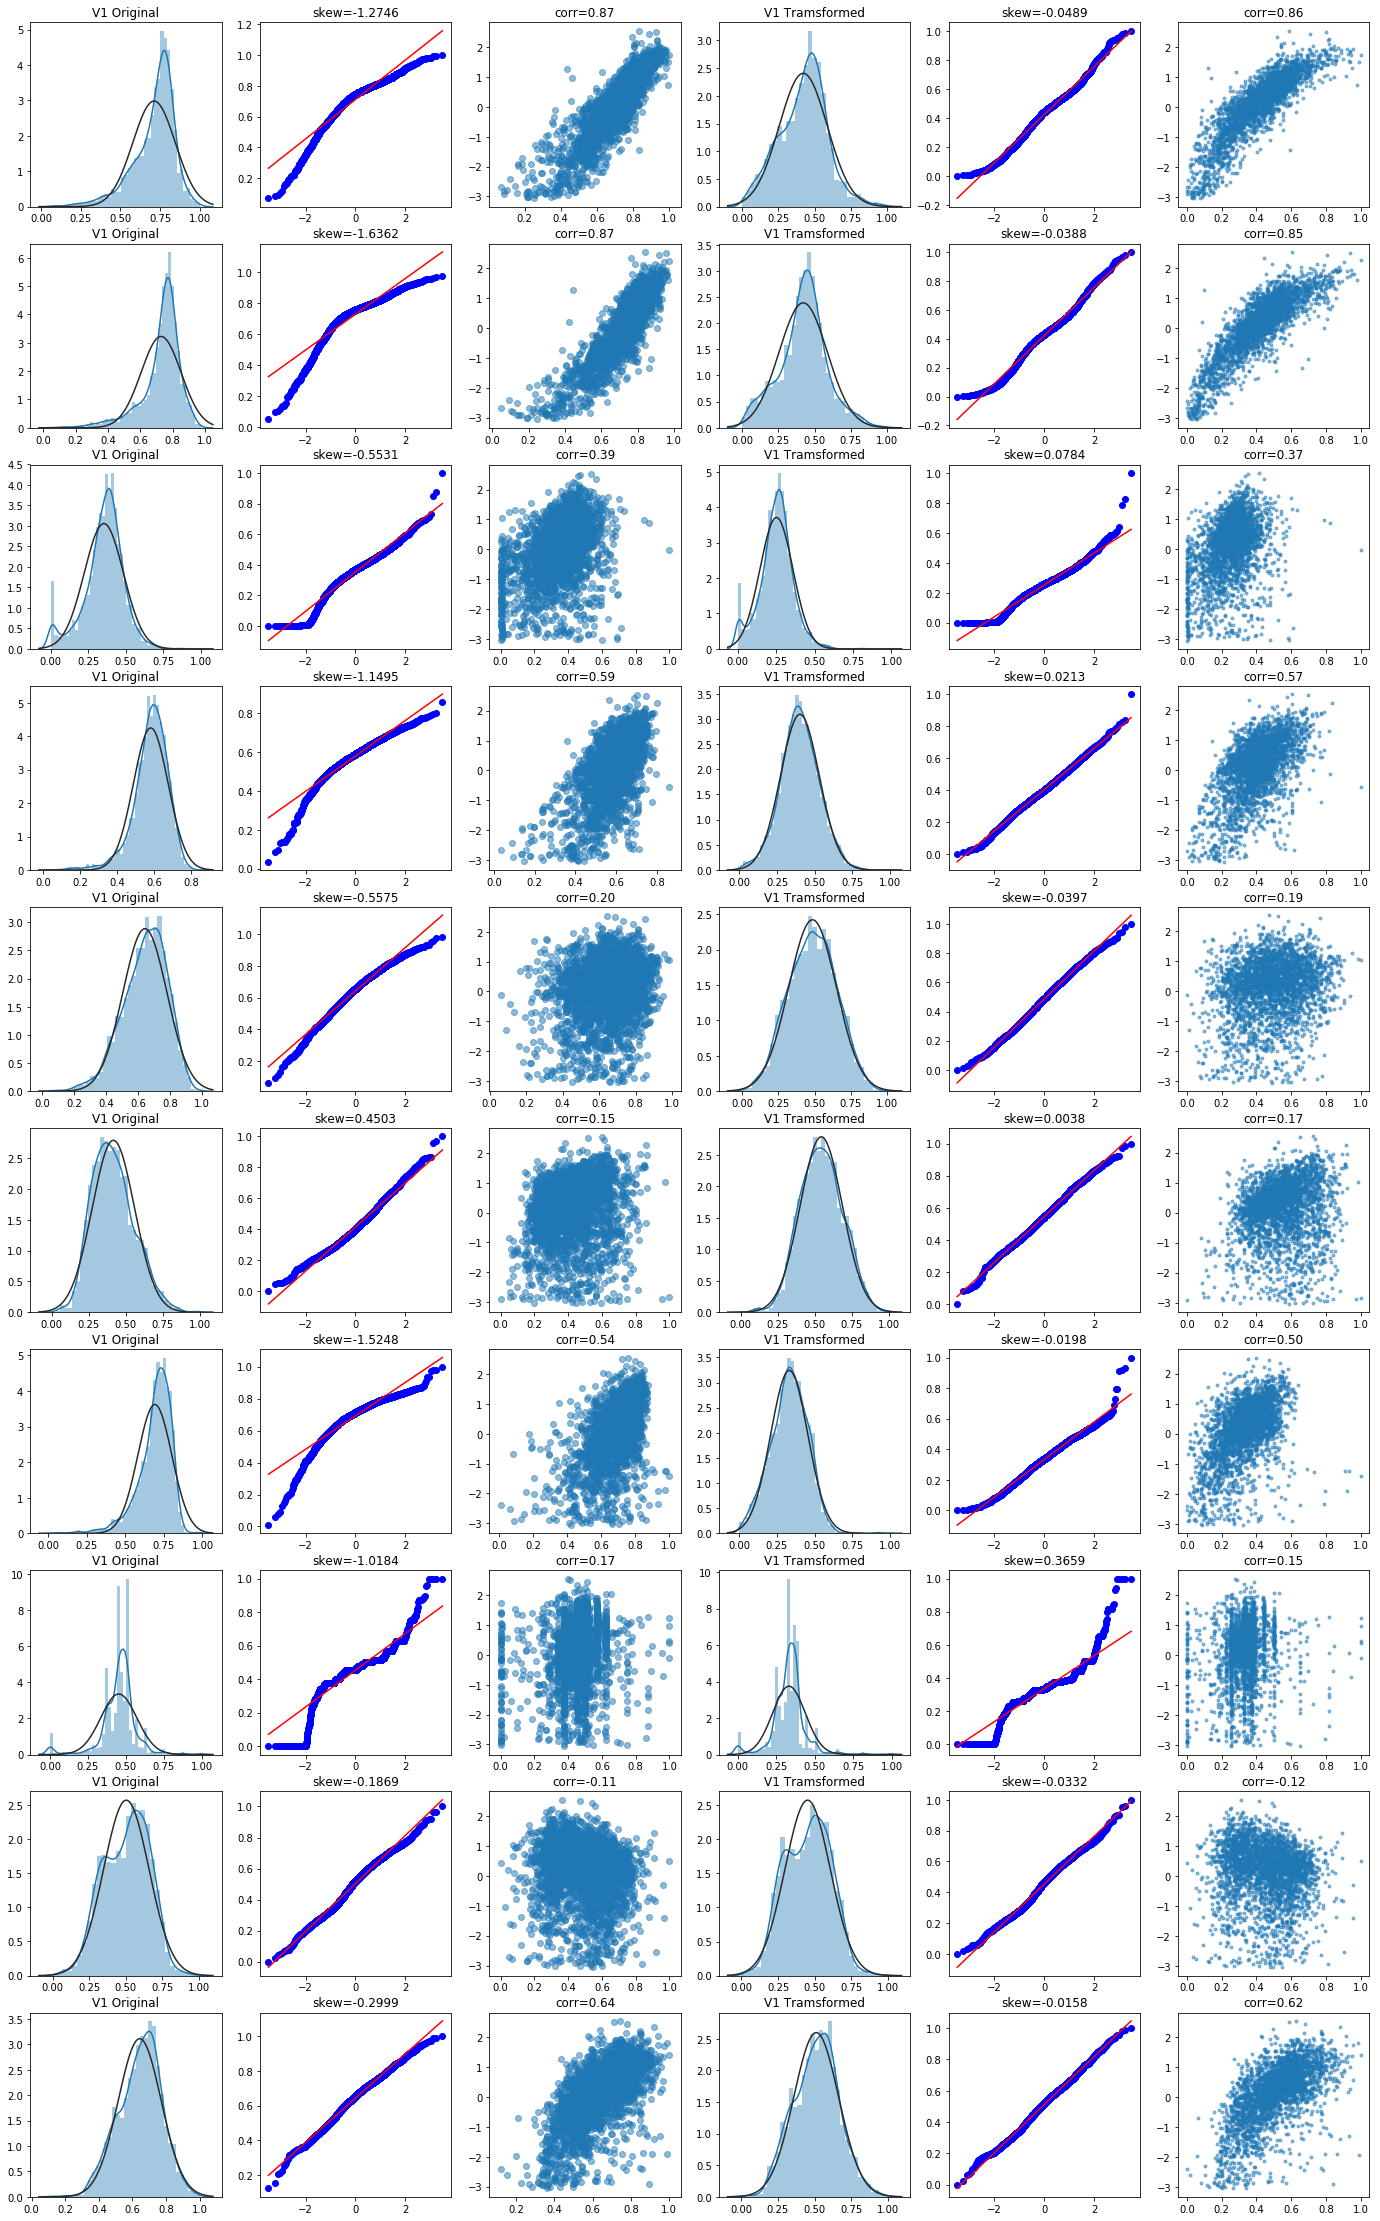

In [196]:
#Check effect of Box-Cox transforms on distributions of continuous variables
# pip install scipy
from scipy import stats
fcols = 6
frows = len(data_all_norm.columns[:10])
plt.figure(figsize=(4*fcols,4*frows))
i=0

for col in data_all_norm.columns[:10]:
    dat = data_all_norm[[col, 'target']].dropna()

#     这条线就是数据分布dist：distribution（分布）
    i+=1
    plt.subplot(frows,fcols,i)
    sns.distplot(dat[col],fit = stats.norm);
    plt.title(var+' Original')
    plt.xlabel('')

#     第二个图：skew统计分析中中一个属性
#     skewness 偏斜系数，对正太分布的度量
    i+=1
    plt.subplot(frows,fcols,i)
    _=stats.probplot(dat[col], plot=plt)#画图，偏析度
    plt.title('skew='+'{:.4f}'.format(stats.skew(dat[col])))
    plt.xlabel('')
    plt.ylabel('')

#     散点图
    i+=1
    plt.subplot(frows,fcols,i)
#     plt.plot(dat[var], dat['target'],'.',alpha=0.5)
    plt.scatter(dat[col],dat['target'],alpha=0.5)
    plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[col], dat['target'])[0][1]))

#     ！！！对数据进行了处理！！！
#   数据分布图distribution
    i+=1
    plt.subplot(frows,fcols,i)
    trans_var, lambda_var = stats.boxcox(dat[col].dropna()+1)
    trans_var = scale_minmax(trans_var)      
    sns.distplot(trans_var , fit=stats.norm);
    plt.title(var+' Tramsformed')
    plt.xlabel('')

#     偏斜度
    i+=1
    plt.subplot(frows,fcols,i)
    _=stats.probplot(trans_var, plot=plt)
    plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
    plt.xlabel('')
    plt.ylabel('')

#     散点图
    i+=1
    plt.subplot(frows,fcols,i)
    plt.plot(trans_var, dat['target'],'.',alpha=0.5)
    plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

In [200]:
# 将数据进行Box-Cox转换
# 统计建模中常用的数据变化
# 数据更加正态化，标准化
for col in data_all_norm.columns[:-2]:
    boxcox,maxlog = stats.boxcox(data_all_norm[col] + 1)
    data_all_norm[col] = scale_minmax(boxcox)

### 过滤异常值

40


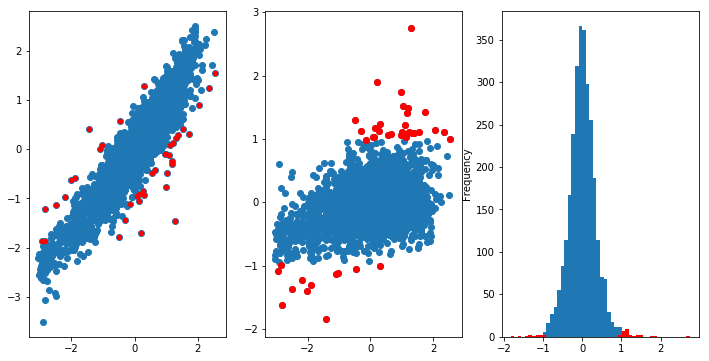

In [207]:
ridge = RidgeCV(alphas=[0.0001,0.001,0.01,0.1,0.2,0.5,1,2,3,4,5,10,20,30,50])

cond = data_all_norm['origin'] == 'train'

X_train = data_all_norm[cond].iloc[:,:-2]
# 真实值
y_train = data_all_norm[cond]['target']
# 算法拟合数据和目标值的时候，不可能100%拟合
ridge.fit(X_train,y_train)
# 预测，预测值肯定会和真实值有一定的偏差，偏差特别大，当成异常值
y_ = ridge.predict(X_train)

cond = abs(y_ - y_train) > y_train.std()
print(cond.sum())
# 画图
plt.figure(figsize=(12,6))
axes = plt.subplot(1,3,1)
axes.scatter(y_train,y_)
axes.scatter(y_train[cond],y_[cond],c = 'red',s = 20)

axes = plt.subplot(1,3,2)
axes.scatter(y_train,y_train - y_)
axes.scatter(y_train[cond],(y_train - y_)[cond],c = 'red')

axes = plt.subplot(1,3,3)
# _ = axes.hist(y_train,bins = 50)
(y_train - y_).plot.hist(bins = 50,ax = axes)
(y_train - y_).loc[cond].plot.hist(bins = 50,ax = axes,color = 'r')

In [209]:
index = cond[cond].index

data_all_norm.drop(index,axis = 0,inplace=True)

In [210]:
cond = data_all_norm['origin'] == 'train'
X_train = data_all_norm[cond].iloc[:,:-2]
y_train = data_all_norm[cond]['target']

cond = data_all_norm['origin'] == 'test'
X_test = data_all_norm[cond].iloc[:,:-2]

In [211]:
estimators = {}
# estimators['linear'] = LinearRegression()
# estimators['ridge'] = Ridge()
# estimators['lasso'] = Lasso()
estimators['forest'] = RandomForestRegressor(n_estimators=300)
estimators['gbdt'] = GradientBoostingRegressor(n_estimators=300)
estimators['ada'] = AdaBoostRegressor(n_estimators=300)
estimators['extreme'] = ExtraTreesRegressor(n_estimators=300)
estimators['svm_rbf'] = SVR(kernel='rbf')
estimators['light'] = LGBMRegressor(n_estimators=300)
estimators['xgb'] = XGBRegressor(n_estimators=300)

In [212]:
result = []
for key,model in estimators.items():
    model.fit(X_train,y_train)
    y_ = model.predict(X_test)
    result.append(y_)
y_ = np.mean(result,axis = 0)

pd.Series(y_).to_csv('./norm.txt',index = False)